In [1]:
# model selection
from ml.models.clustering import KMeans
from ml.functions.metrics.regression import RMSE
from ml.functions.distance import EuclideanDistance


# data manipulation
from ml.dataset import load_csv
from ml.algorithms.normalization import MinMaxScaler

# Utility
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

np.random.seed(20)

## Q1 - K-Means

#### Load dataset

In [2]:
X_quake, _ = load_csv('./datasets/quake.csv', no_output=True)

scaler = MinMaxScaler()
scaler.fit(X_quake)

X_quake_scaled = scaler.transform(X_quake)

### Q1.a - find best K from DB-index with euclidean distance

In [3]:
best_db = None
best_model = None
global_dbs = []
global_errs = []

for num_clusters in np.arange(4, 21):
    best_local_k = None
    best_local_db = None
    best_local_model = None
    
    for i in range(20):
        model = KMeans(num_clusters, 1000, distance=EuclideanDistance)

        err, centroids = model.fit(X_quake_scaled)
        db = model.db_index(X_quake_scaled)
        
        if best_local_db is None or db < best_local_db:
            best_local_db = db
            best_local_model = model
            best_local_k = num_clusters
    
    if best_db is None or best_local_db < best_db:
        best_db = best_local_db
        best_model = best_local_model
    
    # keep track DB-indexes and reconstruction errors
    global_dbs.append(best_local_db)
    global_errs.append(best_local_model.errors[-1])

    clear_output(wait=True)
    display("K="+str(num_clusters)+" - DB-index="+str(best_local_db))

'K=20 - DB-index=0.6305299240326894'

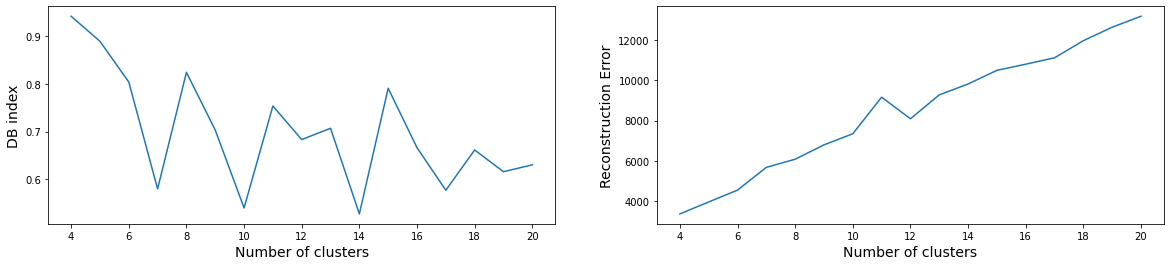

In [4]:
fig, axs = plt.subplots(1,2, figsize=(20,4), sharey=False)
axs[0].plot(np.arange(4, 21), global_dbs)
axs[1].plot(np.arange(4, 21), global_errs)

axs[0].set_xlabel("Number of clusters", size=14)
axs[1].set_xlabel("Number of clusters", size=14)

axs[0].set_ylabel("DB index", size=14)
axs[1].set_ylabel("Reconstruction Error", size=14)
plt.show()

#### Best model

[BEST] -> K=14, DB-index=0.5279269350978196, ReconstructionError=9816.207613569915


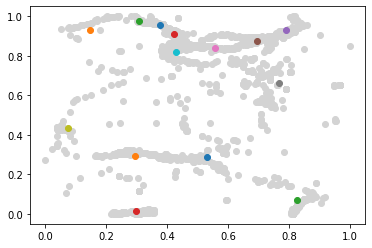

In [6]:
print(f"[BEST] -> K={best_model.num_clusters}, DB-index={best_db}, ReconstructionError={best_model.errors[-1]}")

plt.scatter(X_quake_scaled[:,0], X_quake_scaled[:,1], c='lightgray')

for k in range(best_model.num_clusters):
    plt.scatter(best_model.centroids[k, 0, 0], best_model.centroids[k, 0, 1])


plt.rcParams["figure.figsize"] = (8, 6)
plt.show()

### Q1.b - find best K from DB-index with Mahalanobis distance
TBD

## Q2 - PCA

### Prepare dataset

In [7]:
X_penguin, _ = load_csv('./datasets/penguins.csv')

In [8]:
penguin_data_scaler = MinMaxScaler()
penguin_data_scaler.fit(X_penguin)

X_penguin_scaled = penguin_data_scaler.transform(X_penguin)

mean = np.mean(X_penguin_scaled, axis=0, keepdims=True)
X_penguin_centralized = X_penguin_scaled - mean

### SVD decomposition

In [9]:
U, S, V = np.linalg.svd(X_penguin_centralized, full_matrices=True)

### Q2.a - Data projection
A projection matrix P is given by U.T, and a projection is computed by P@S


In [10]:
num_dims = 2

# projection matrix
P = U[:,:num_dims]

# projected dataset
projected_2D = P @ np.diag(S[:num_dims])

# reconstructed dataset
reconstructed_4D = (projected_2D @ P.T) @ U[:,:4]
reconstruction_error = RMSE().measure(X_penguin_centralized, reconstructed_4D)
print(f"Reconstruction error: {reconstruction_error}")

Reconstruction error: 0.29030794137413984


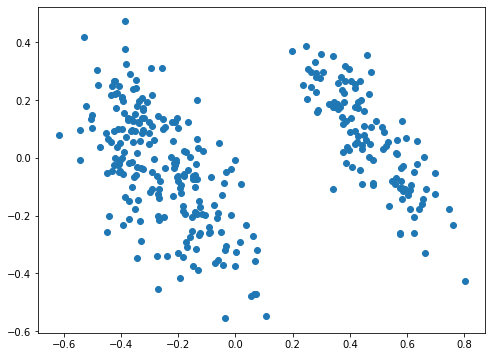

In [11]:
# Plotting 2D projection of the dataset
x_proj = projected_2D[:, 0]
y_proj = projected_2D[:, 1]
plt.scatter(x_proj, y_proj)
plt.show()

### Q2.b - Exaplanable Variance

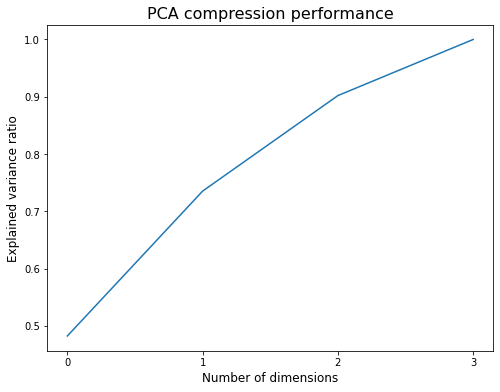

In [12]:
num_dimensions = np.arange(X_penguin_centralized.shape[1])

normalized_s = S/np.sum(S)
explainable_variance_ratio = np.cumsum(normalized_s)

# plot
plt.plot(num_dimensions, explainable_variance_ratio)
plt.title("PCA compression performance", size=16)
plt.ylabel("Explained variance ratio", size=12)
plt.xlabel("Number of dimensions", size=12)
plt.xticks(num_dimensions)
plt.show()
